### **Chunk 8: Handling Real-World Data Issues**

#### **1. Concept Introduction**

This chunk enhances the skills you learned in the pipeline lesson. We're moving from basic preprocessing to more sophisticated and robust techniques for common data problems.

-   **Advanced Imputation**: `SimpleImputer` is a good start, but it's naive. It doesn't use relationships between features.
    -   **`IterativeImputer`**: A much smarter approach. To fill missing values in a column (e.g., `Age`), it uses all the *other* features in the dataset to train a regression model and predict what the missing age should be. It does this iteratively for all columns with missing values, refining its estimates each time. It's computationally more expensive but often more accurate.

-   **Advanced Categorical Encoding**:
    -   **`OneHotEncoder`**: You've mastered this. It's perfect for **nominal** categorical features where there is no inherent order (e.g., `Embarked`: Southampton vs. Cherbourg vs. Queenstown).
    -   **`OrdinalEncoder`**: Use this for **ordinal** categorical features where there *is* a meaningful order (e.g., `Education`: 'High School' < 'Bachelors' < 'Masters'). It encodes the categories as integers (0, 1, 2), preserving this order. Using it on nominal data can mislead your model.
    -   **`TargetEncoder`**: A powerful but advanced technique. For each category, it calculates the mean of the target variable. For example, it would replace 'male' and 'female' with the average survival rate for each gender. This creates a very predictive feature but carries a high risk of overfitting and data leakage if not used carefully inside a cross-validation loop. We'll use this in later projects.

-   **Outlier Detection**: Outliers are data points that are significantly different from other observations. They can skew scalers (like `MinMaxScaler`) and have an outsized influence on models that are sensitive to distance or errors (like `LinearRegression` or SVMs).
    -   **Visualization**: Box plots are the best tool for a quick visual inspection of outliers.
    -   **Statistical Methods**: A common rule of thumb is to consider anything outside 1.5 times the Interquartile Range (IQR) as a potential outlier.
    -   **Impact**: Tree-based models like `RandomForest` are generally robust to outliers because their splitting logic is not affected by the magnitude of a single point. This is a major reason for their popularity.

#### **2. Dataset EDA: The Titanic Dataset**

The most famous dataset in machine learning. The goal is to predict which passengers survived the sinking of the Titanic.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

# Set plot style
sns.set_style('whitegrid')

In [2]:
titanic = fetch_openml(name="titanic",
                       version=1,
                       as_frame=True,
                       parser='auto')
df = titanic.frame
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# Clean column names and target
df.rename(columns={
    'pclass': 'Pclass',
    'survived' : 'Survived',
}, inplace=True)
df['Survived'] = df['Survived'].astype(int)

# Drop the columns that are not useful for a first-pass model
df = df.drop(['boat', 'body', 'home.dest', 'name', 'ticket'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Pclass    1309 non-null   int64   
 1   Survived  1309 non-null   int64   
 2   sex       1309 non-null   category
 3   age       1046 non-null   float64 
 4   sibsp     1309 non-null   int64   
 5   parch     1309 non-null   int64   
 6   fare      1308 non-null   float64 
 7   cabin     295 non-null    object  
 8   embarked  1307 non-null   category
dtypes: category(2), float64(2), int64(4), object(1)
memory usage: 74.5+ KB


**Missing Value Analysis**

In [4]:
df.isnull().sum()
# age, fair, cabin, embarked all have missing values.
# cabin has too many values to be easily imputed. We'll drop it

Pclass         0
Survived       0
sex            0
age          263
sibsp          0
parch          0
fare           1
cabin       1014
embarked       2
dtype: int64

**Target Variable Distribution**

Target Variable Distribution
Survived
0    809
1    500
Name: count, dtype: int64


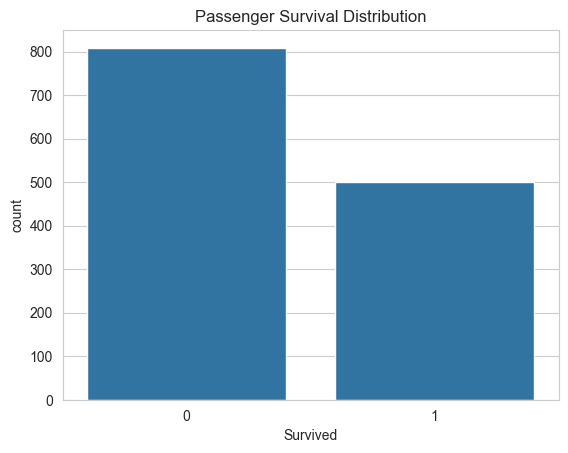

In [5]:
print("Target Variable Distribution")
print(df['Survived'].value_counts())
sns.countplot(x='Survived', data=df)
plt.title('Passenger Survival Distribution')
plt.show()

hmmm. very slight imbalance

**Survival by key Categorical features**

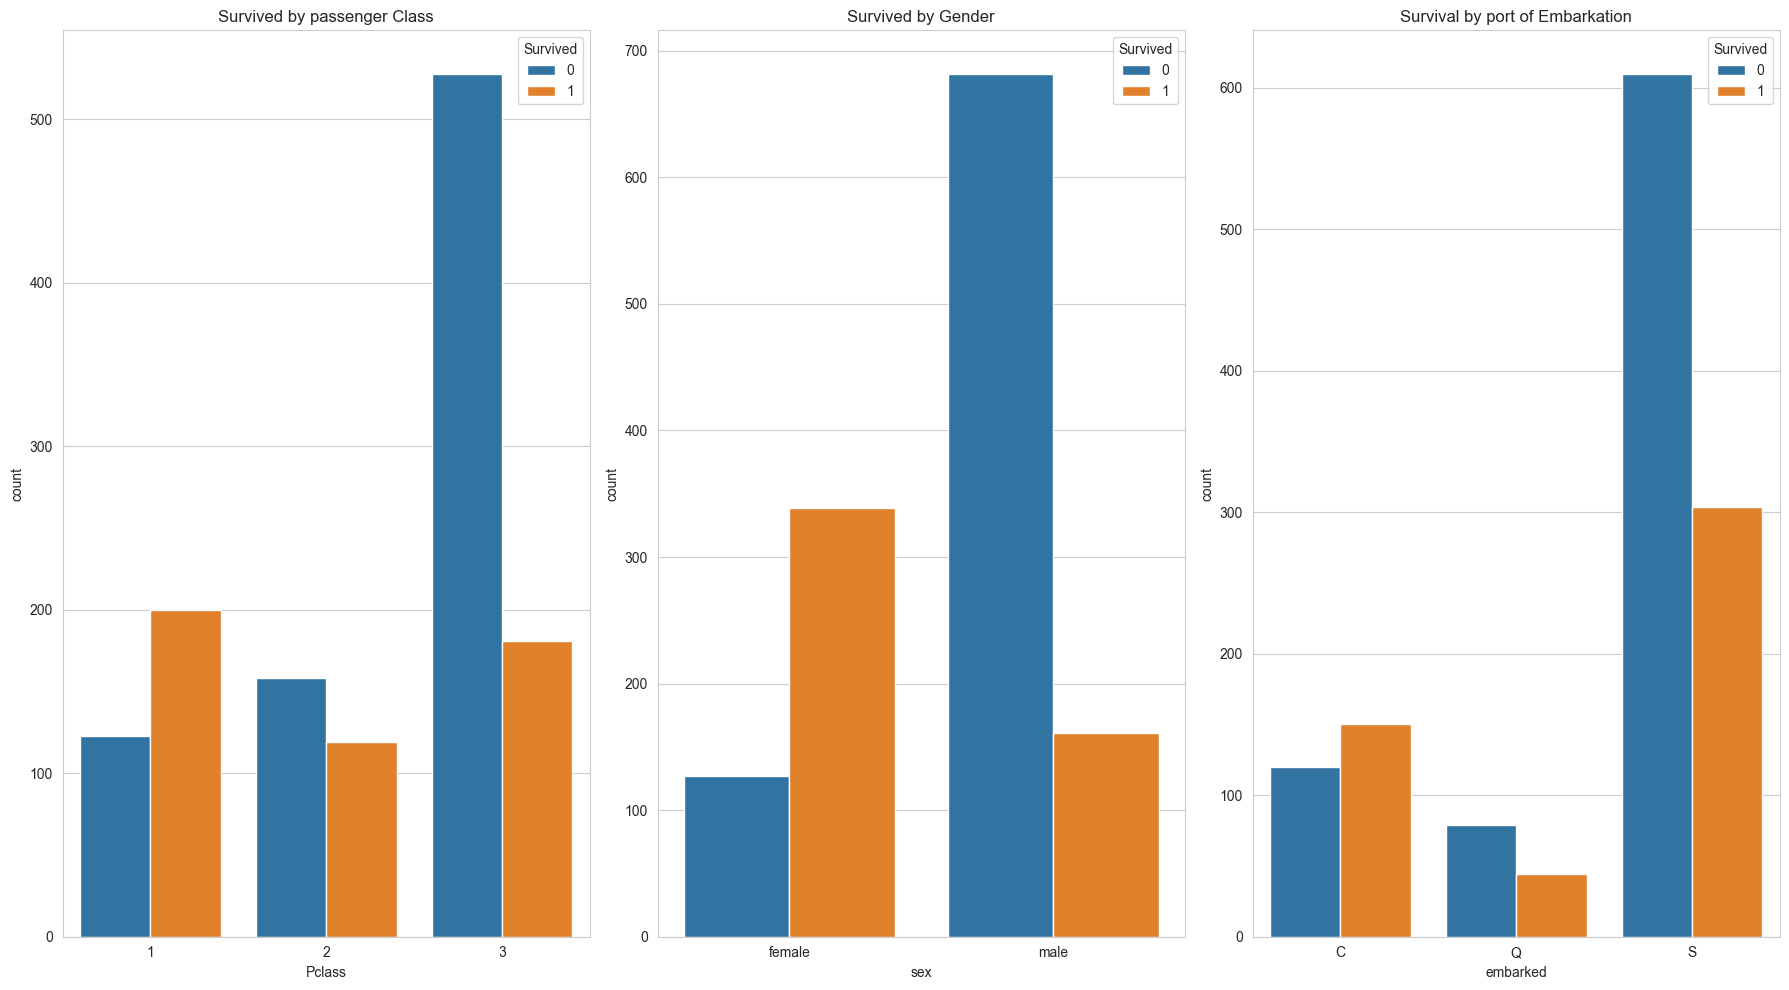

In [6]:
from matplotlib.pyplot import axis
fig, axes = plt.subplots(1, 3, figsize=(18, 10))
sns.countplot(ax=axes[0],
              x='Pclass',
              hue='Survived',
              data=df)
axes[0].set_title('Survived by passenger Class')

sns.countplot(ax=axes[1],
              x='sex',
              hue='Survived',
              data=df)
axes[1].set_title('Survived by Gender')

sns.countplot(ax=axes[2],
x='embarked',
hue='Survived',
data=df)
axes[2].set_title('Survival by port of Embarkation')

plt.tight_layout()
plt.show()

**Survival by numerical Features**

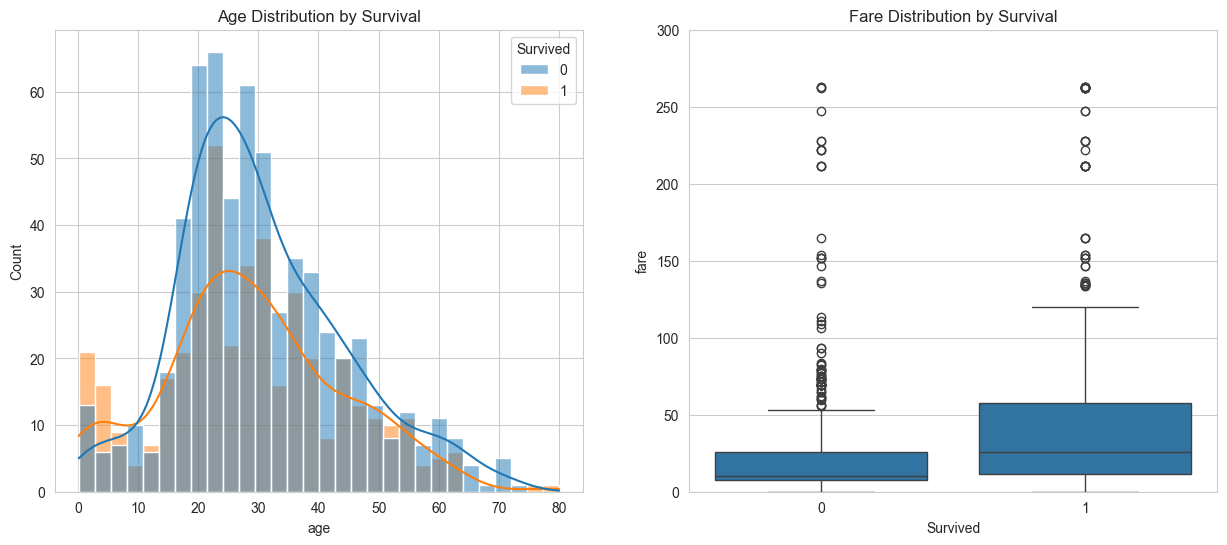

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(ax=axes[0],
data=df,
x='age',
hue='Survived',
kde=True,
bins=30)
axes[0].set_title('Age Distribution by Survival')

sns.boxplot(ax=axes[1],
data=df,
x='Survived',
y='fare')
axes[1].set_title('Fare Distribution by Survival')
axes[1].set_ylim(0, 300) # zoom in to see the distribution better, ignoring extreme outliers
plt.show()

#### **3. Minimal Working Example: The Robust Pipeline**
Let's build a pipeline that handles all these issues using or new, more advanced tools

In [8]:
from       sklearn.model_selection import train_test_split
from       sklearn.pipeline        import Pipeline
from       sklearn.impute          import SimpleImputer
from       sklearn.experimental    import enable_iterative_imputer # required for IterativeImputer
from       sklearn.impute          import IterativeImputer
from       sklearn.preprocessing   import StandardScaler, OneHotEncoder, OrdinalEncoder
from       sklearn.compose         import ColumnTransformer
from       sklearn.ensemble        import RandomForestClassifier
from       sklearn.metrics         import accuracy_score

# For now let's drop the 'cabin' due to excessive missing values, and 'sibsp', 'parch' for simplicity
# In a real project, we would engineer a 'FamilySize' feature from sibsp and parch

X = df.drop(['Survived', 'cabin'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=y)


*Define Column types for our pipeline*

In [9]:
df.columns

Index(['Pclass', 'Survived', 'sex', 'age', 'sibsp', 'parch', 'fare', 'cabin',
       'embarked'],
      dtype='object')

In [10]:
numeric_features = ['age', 'fare', 'sibsp', 'parch']
ordinal_features = ['Pclass']
nominal_features = ['sex', 'embarked']

**Create the Preprocessing Pipeline**

In [11]:
df.Pclass.unique()

array([1, 2, 3])

In [12]:
numeric_transformer = Pipeline(steps=[
    # Using the powerful IterativeImputer for numeric columns
    ('imputer', IterativeImputer(max_iter=10, random_state=42)),
    ('scaler', StandardScaler())
])

# No special imputation needed for Pclass as it has no missing values
ordinal_transformer = Pipeline([
    ('encoder', OrdinalEncoder(categories=[[1,2,3]]))# Explicitly define the order
])

nominal_encoder = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

**Create the Master preprocessor with ColumnTransformer**

In [13]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', ordinal_transformer, ordinal_features),
        ('nom', nominal_encoder, nominal_features)
    ],
    remainder='passthrough'
)


**Create and evaluate the full pipeline**
> A RandomForest is a great choice here due to its robustness to outliers and complex interactions

In [16]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train and score
full_pipeline.fit(X_train, y_train)
accuracy = full_pipeline.score(X_test, y_test)
print(f"Pipeline Accuracy: {accuracy * 100:.2f}%")


Pipeline Accuracy: 78.24%


#### **4. Common Pitfalls**

1.  **Imputing Before Feature Engineering**: If you were to create a `FamilySize` feature (`sibsp` + `parch` + 1), you should do it *before* the imputation step, as the new feature might help the imputer make better predictions.
2.  **Using `IterativeImputer` on a Massive Dataset**: It can be very slow. For datasets with millions of rows, `SimpleImputer` is often a more practical choice.
3.  **Applying the Wrong Encoder**: Using `OrdinalEncoder` for `embarked` would teach the model a false and meaningless relationship like `Southampton > Queenstown`, which could harm performance.
4.  **Dropping "Missing" Data Blindly**: Dropping the `cabin` column was a pragmatic choice for this lesson. In a real project (like a Kaggle competition), the very fact that `cabin` is missing could be a predictive feature itself. You might engineer a new feature called `has_cabin` (1 if a cabin number exists, 0 if not).

#### **Congratulations.**

You have successfully navigated a genuinely messy, real-world dataset from start to finish. You have handled missing values with sophisticated techniques, applied multiple types of encoders based on the nature of the features, and bundled it all into a single, robust, professional pipeline.

This chunk completes **Phase 1: Bare Fundamentals**.

Take a moment to look back. You started with zero practical scikit-learn experience. You can now:
-   Fluently speak the `fit`/`transform`/`predict` language of the API.
-   Prepare data by scaling, imputing, and encoding.
-   Train and evaluate both classification and regression models.
-   Understand the trade-offs between different evaluation metrics.
-   Leverage powerful ensemble models like `RandomForest`.
-   Build leak-proof, professional pipelines with `Pipeline` and `ColumnTransformer`.
-   Perform state-of-the-art hyperparameter tuning with **Optuna**.

You have built the complete scaffolding of a machine learning practitioner. You have all the fundamental tools.

But the real journey, the path to mastery, is not just about knowing the tools—it's about knowing *how and when* to apply them to solve complex, ambiguous problems. It's about feature engineering, handling extreme challenges like massive class imbalance, and building systems that deliver real-world value.

It is time to begin **Phase 2: Project-Driven Mastery**.